In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
import yfinance as yf 
from _regime_detection import *

warnings.filterwarnings("ignore")
sns.set_theme()

In [26]:
data = yf.download("TSLA")
data.drop(["Adj Close"], axis=1, inplace=True)
data.columns = ["open", 'high', 'low', "close", 'volume']
data.head()

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,volume
Date,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500


In [27]:
# resample data to 2 week or weekly 
weekly_data = data.resample('2W').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})
weekly_data

,open,high,low,close,volume
Date,,,,,
2010-07-04,1.266667,2.028000,1.169333,1.280000,739680000
2010-07-18,1.333333,1.433333,0.998667,1.376000,614842500
2010-08-01,1.424667,1.483333,1.300000,1.329333,153415500
2010-08-15,1.366667,1.478667,1.159333,1.221333,129244500
2010-08-29,1.230000,1.359333,1.217333,1.313333,82320000
...,...,...,...,...,...
2023-08-27,235.699997,240.820007,212.360001,238.589996,1129577300
2023-09-10,242.580002,261.179993,235.350006,248.500000,1084953900
2023-09-24,264.269989,278.980011,244.479996,244.880005,1238291100


<Axes: xlabel='Date'>

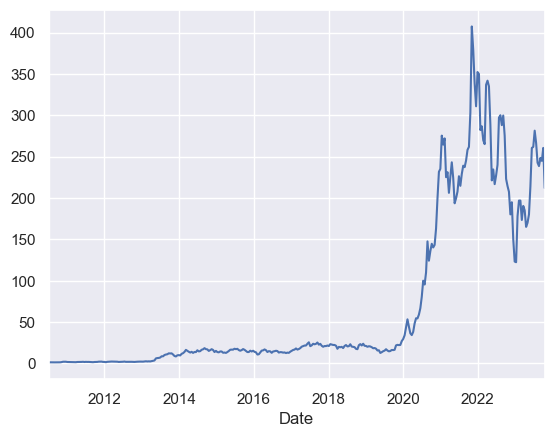

In [28]:
weekly_data["close"].plot()

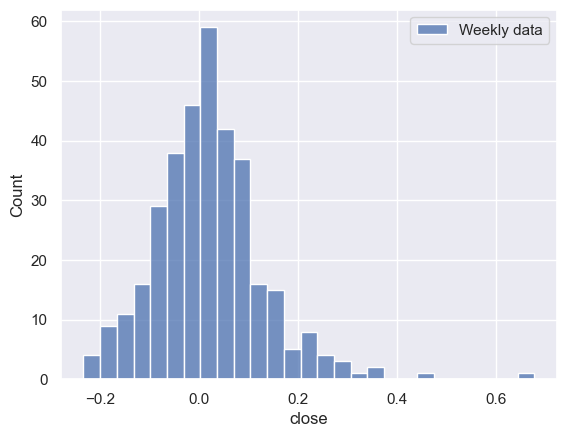

In [29]:
sns.histplot(weekly_data["close"].pct_change(), label="Weekly data")
plt.legend()
plt.show()

In [30]:
weekly_returns = weekly_data.pct_change()
weekly_returns.dropna(inplace=True)
weekly_returns

,open,high,low,close,volume
Date,,,,,
2010-07-18,0.052631,-0.293228,-0.145952,0.075000,-0.168772
2010-08-01,0.068501,0.034884,0.301735,-0.033915,-0.750480
2010-08-15,-0.040711,-0.003146,-0.108205,-0.081244,-0.157553
2010-08-29,-0.100000,-0.080704,0.050029,0.075328,-0.363068
2010-09-12,0.067750,0.044630,0.058599,0.023858,-0.335805
...,...,...,...,...,...
2023-08-27,-0.118813,-0.105024,-0.107806,-0.016732,0.147928
2023-09-10,0.029190,0.084544,0.108260,0.041536,-0.039505
2023-09-24,0.089414,0.068152,0.038793,-0.014567,0.141331


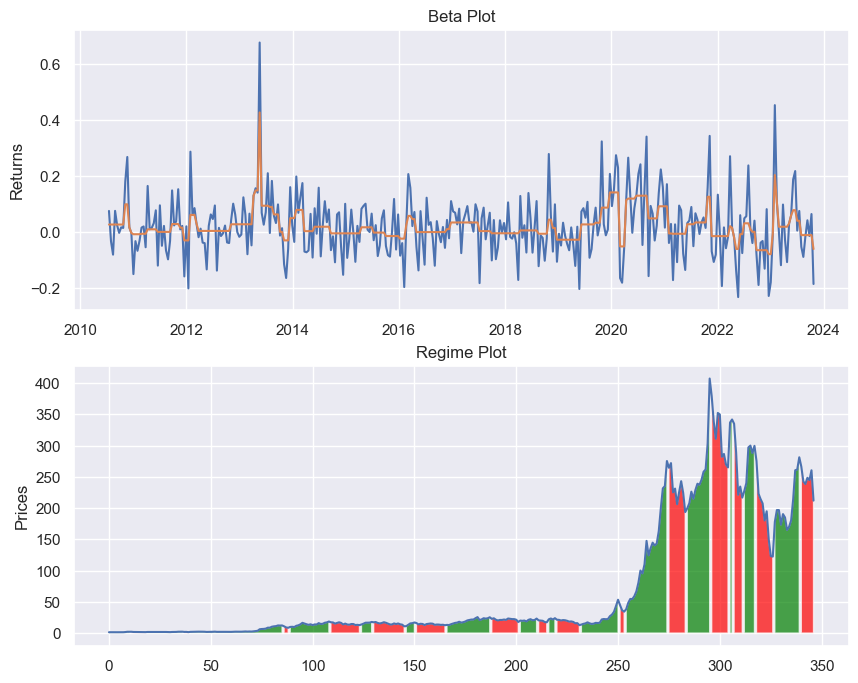

In [61]:
regime_obj = RegimeDetection(weekly_returns)
beta = regime_obj.trend_filtering(rets=weekly_returns, lambda_value=0.25)
trend = regime_obj.regime_switch_series(beta)

x = range(len(weekly_returns))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(weekly_returns["close"])
ax1.plot(beta["close"])
ax1.set_title("Beta Plot")
ax1.set_ylabel("Returns")

ax2.plot(x, weekly_data["close"].iloc[1:])
ax2.fill_between(x, weekly_data["close"].iloc[1:], where=trend["close"] == 1, facecolor='green', alpha=0.7)
ax2.fill_between(x, weekly_data["close"].iloc[1:], where=trend["close"] == -1, facecolor='red', alpha=0.7)
ax2.set_title("Regime Plot")
ax2.set_ylabel("Prices")
plt.show()


# Train Model 


In [62]:
import xgboost as xgb 
import lightgbm as lgb 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 


In [65]:
weekly_returns["trend"] = trend["close"] 
weekly_returns

,open,high,low,close,volume,trend
Date,,,,,,
2010-07-18,0.052631,-0.293228,-0.145952,0.075000,-0.168772,1.0
2010-08-01,0.068501,0.034884,0.301735,-0.033915,-0.750480,1.0
2010-08-15,-0.040711,-0.003146,-0.108205,-0.081244,-0.157553,1.0
2010-08-29,-0.100000,-0.080704,0.050029,0.075328,-0.363068,1.0
2010-09-12,0.067750,0.044630,0.058599,0.023858,-0.335805,1.0
...,...,...,...,...,...,...
2023-08-27,-0.118813,-0.105024,-0.107806,-0.016732,0.147928,-1.0
2023-09-10,0.029190,0.084544,0.108260,0.041536,-0.039505,-1.0
2023-09-24,0.089414,0.068152,0.038793,-0.014567,0.141331,-1.0


In [70]:
weekly_returns["target"] = weekly_returns["trend"].shift(-1)
weekly_returns.dropna(inplace=True)

X, y = weekly_returns.drop(["target", "trend"], axis=1), np.where(weekly_returns["target"]==1, 1, 0)
X

,open,high,low,close,volume
Date,,,,,
2010-07-18,0.052631,-0.293228,-0.145952,0.075000,-0.168772
2010-08-01,0.068501,0.034884,0.301735,-0.033915,-0.750480
2010-08-15,-0.040711,-0.003146,-0.108205,-0.081244,-0.157553
2010-08-29,-0.100000,-0.080704,0.050029,0.075328,-0.363068
2010-09-12,0.067750,0.044630,0.058599,0.023858,-0.335805
...,...,...,...,...,...
2023-07-30,0.036674,0.049036,-0.041418,-0.053095,0.251944
2023-08-13,-0.066811,-0.100939,-0.063356,-0.089288,-0.232937
2023-08-27,-0.118813,-0.105024,-0.107806,-0.016732,0.147928


In [72]:
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=False, 
                                                    random_state=42)
print(f"x_train shape is {x_train.shape} and x_test shape is {x_test.shape}")
print(f"y_train shape is {y_train.shape} and y_test shape is {y_test.shape}")

x_train shape is (276, 5) and x_test shape is (69, 5)
y_train shape is (276,) and y_test shape is (69,)


In [104]:
xgb_model_base = xgb.XGBClassifier(tree_method="gpu_hist")

parameter_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 400, 800],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1.0],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1.0]
}
grid = GridSearchCV(estimator=xgb_model_base, cv=3, param_grid=parameter_grid, )
grid.fit(x_train, y_train)

best_model = grid.best_estimator_

print(classification_report(y_test, best_model.predict(x_test)))

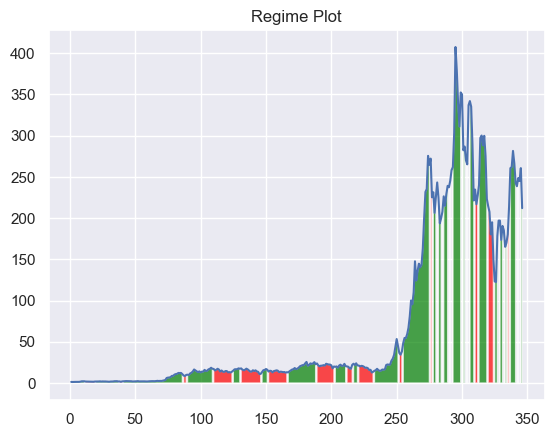

In [103]:
plt.plot(x[1:], weekly_data["close"].iloc[2:])
plt.fill_between(x[2:], weekly_data["close"].iloc[3:], where=best_model.predict(X) == 1, facecolor='green', alpha=0.7)
plt.fill_between(x[2:], weekly_data["close"].iloc[3:], where=best_model.predict(X) == 0, facecolor='red', alpha=0.7)
plt.title("Regime Plot")
plt.show()